In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score
import warnings
import pickle

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")

In [3]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
df.shape

(5110, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [6]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

<Axes: >

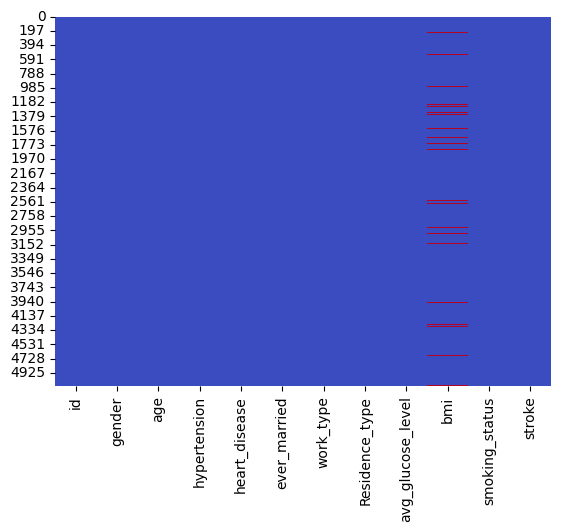

In [7]:
sns.heatmap(df.isnull(), cmap="coolwarm", cbar=False)

Analysis for imputing NAN on BMI


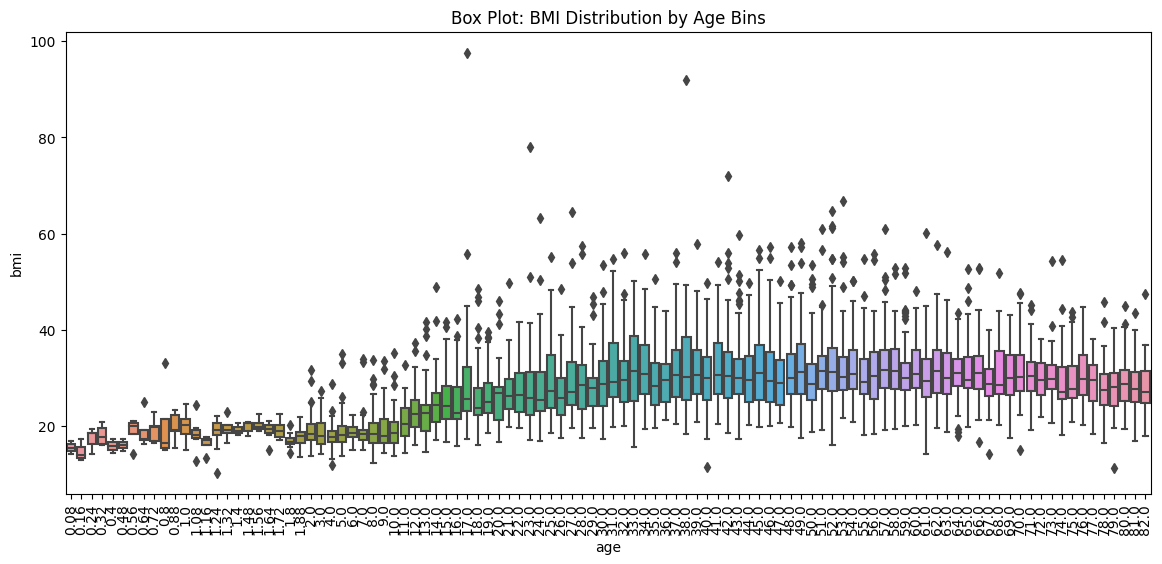

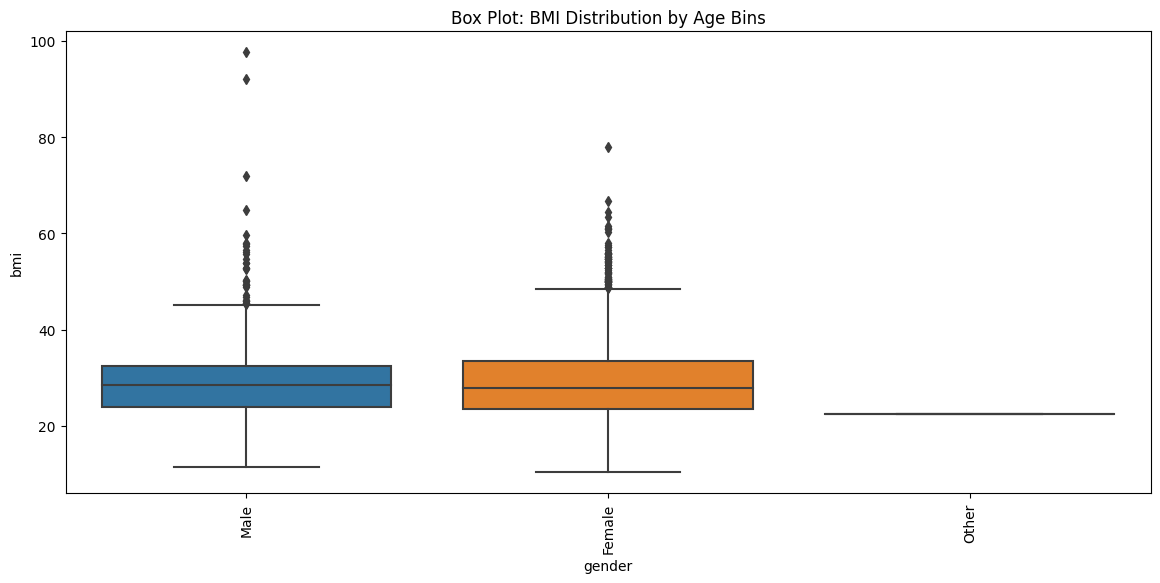

In [8]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x="age", y="bmi")
plt.xticks(rotation=90)
plt.title("Box Plot: BMI Distribution by Age Bins")
plt.show()
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x="gender", y="bmi")
plt.xticks(rotation=90)
plt.title("Box Plot: BMI Distribution by Age Bins")
plt.show()

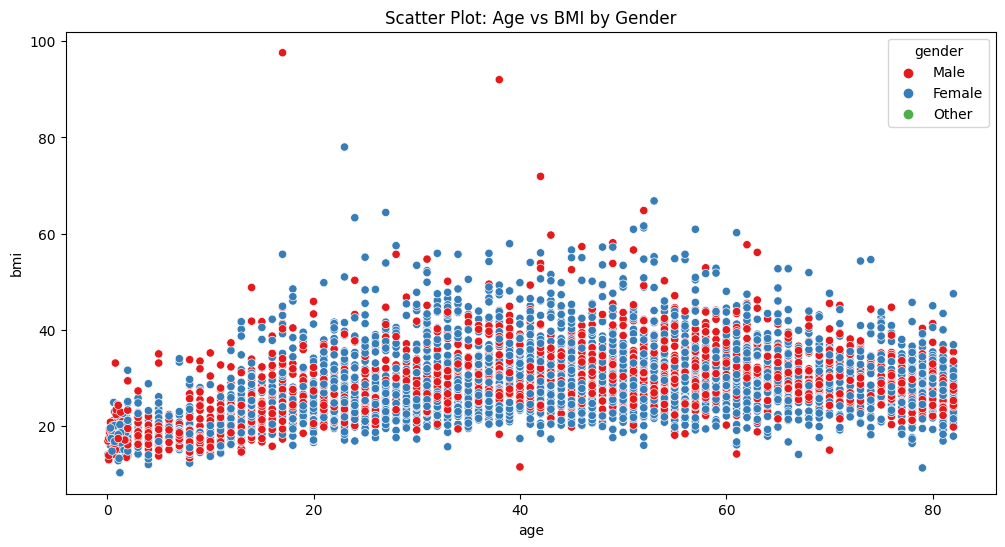

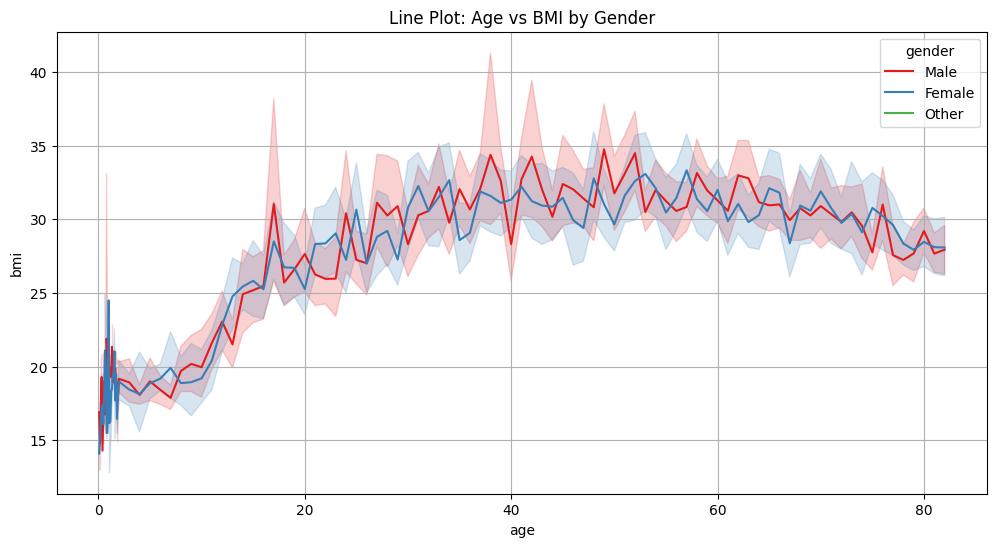

In [9]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x="age", y="bmi", hue="gender", palette="Set1")
plt.title("Scatter Plot: Age vs BMI by Gender")
plt.show()
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="age", y="bmi", hue="gender", palette="Set1")
plt.title("Line Plot: Age vs BMI by Gender")
plt.grid(True)
plt.show()

In [10]:
median_bmi_by_group = df.groupby(["age"])["bmi"].median()

In [11]:
median_bmi_by_group.isnull().sum()

0

In [12]:
df["age"][df.isnull().any(axis=1)].unique()

array([61.  , 59.  , 78.  , 57.  , 58.  , 63.  , 75.  , 76.  , 51.  ,
       66.  , 72.  , 38.  , 65.  , 79.  , 71.  ,  1.32, 64.  , 80.  ,
       77.  , 74.  , 34.  , 54.  , 40.  , 48.  , 31.  , 43.  ,  9.  ,
       52.  , 17.  , 35.  , 23.  , 13.  , 73.  ,  3.  ,  6.  , 46.  ,
       49.  , 25.  , 27.  ,  7.  , 30.  , 47.  , 29.  , 45.  , 69.  ,
       32.  , 60.  , 10.  , 20.  , 67.  , 42.  ,  0.48, 50.  , 19.  ,
       62.  ,  5.  , 14.  , 68.  , 33.  , 56.  , 70.  , 44.  , 39.  ,
       53.  , 41.  ,  1.88, 16.  ,  1.08,  1.8 , 37.  ,  8.  , 82.  ,
       18.  ])

In [13]:
df[df.isnull().any(axis=1)]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
13,8213,Male,78.0,0,1,Yes,Private,Urban,219.84,NaN,Unknown,1
19,25226,Male,57.0,0,1,No,Govt_job,Urban,217.08,NaN,Unknown,1
27,61843,Male,58.0,0,0,Yes,Private,Rural,189.84,NaN,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5039,42007,Male,41.0,0,0,No,Private,Rural,70.15,NaN,formerly smoked,0
5048,28788,Male,40.0,0,0,Yes,Private,Urban,191.15,NaN,smokes,0
5093,32235,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,NaN,smokes,0
5099,7293,Male,40.0,0,0,Yes,Private,Rural,83.94,NaN,smokes,0


In [14]:
def fill_bmi(row):
    if pd.isnull(row["bmi"]):
        return median_bmi_by_group[row["age"]]
    else:
        return row["bmi"]

In [15]:
df["bmi"] = df.apply(fill_bmi, axis=1)

In [16]:
df.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

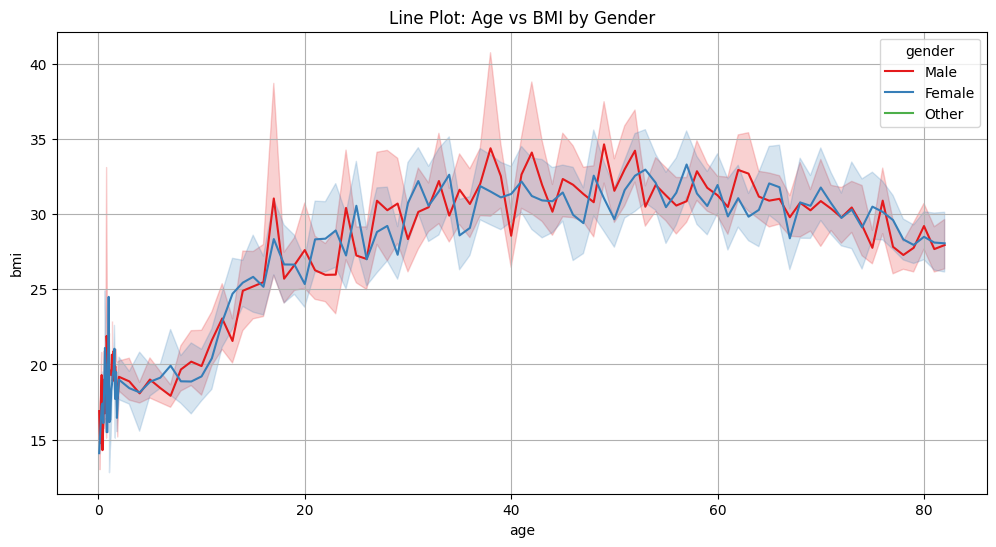

In [17]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="age", y="bmi", hue="gender", palette="Set1")
plt.title("Line Plot: Age vs BMI by Gender")
plt.grid(True)
plt.show()

### Handling Missing BMI Values

#### Initial Problem:

- Upon inspecting the dataset, I found that the `bmi` column had **some missing values (around 200)**.
- Initially, I considered filling these missing values based on both **gender** and **age**.

#### Exploratory Data Analysis (EDA):

- To investigate further, I performed an **EDA** focusing on the relationships between **BMI**, **age**, and **gender**.
- From the analysis, I observed that:

  - **BMI** is **strongly dependent on age**.
  - The relationship between **BMI** and **gender** is much less significant.

  Based on these findings, I decided to impute missing `bmi` values using the **median BMI for each age group** rather than considering gender.


In [18]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,29.45,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.40,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1


In [19]:
df.drop("id", axis=1, inplace=True)

In [20]:
num_col = ["age", "avg_glucose_level", "bmi"]
cat_col = [
    "gender",
    "hypertension",
    "heart_disease",
    "ever_married",
    "work_type",
    "Residence_type",
    "smoking_status",
]

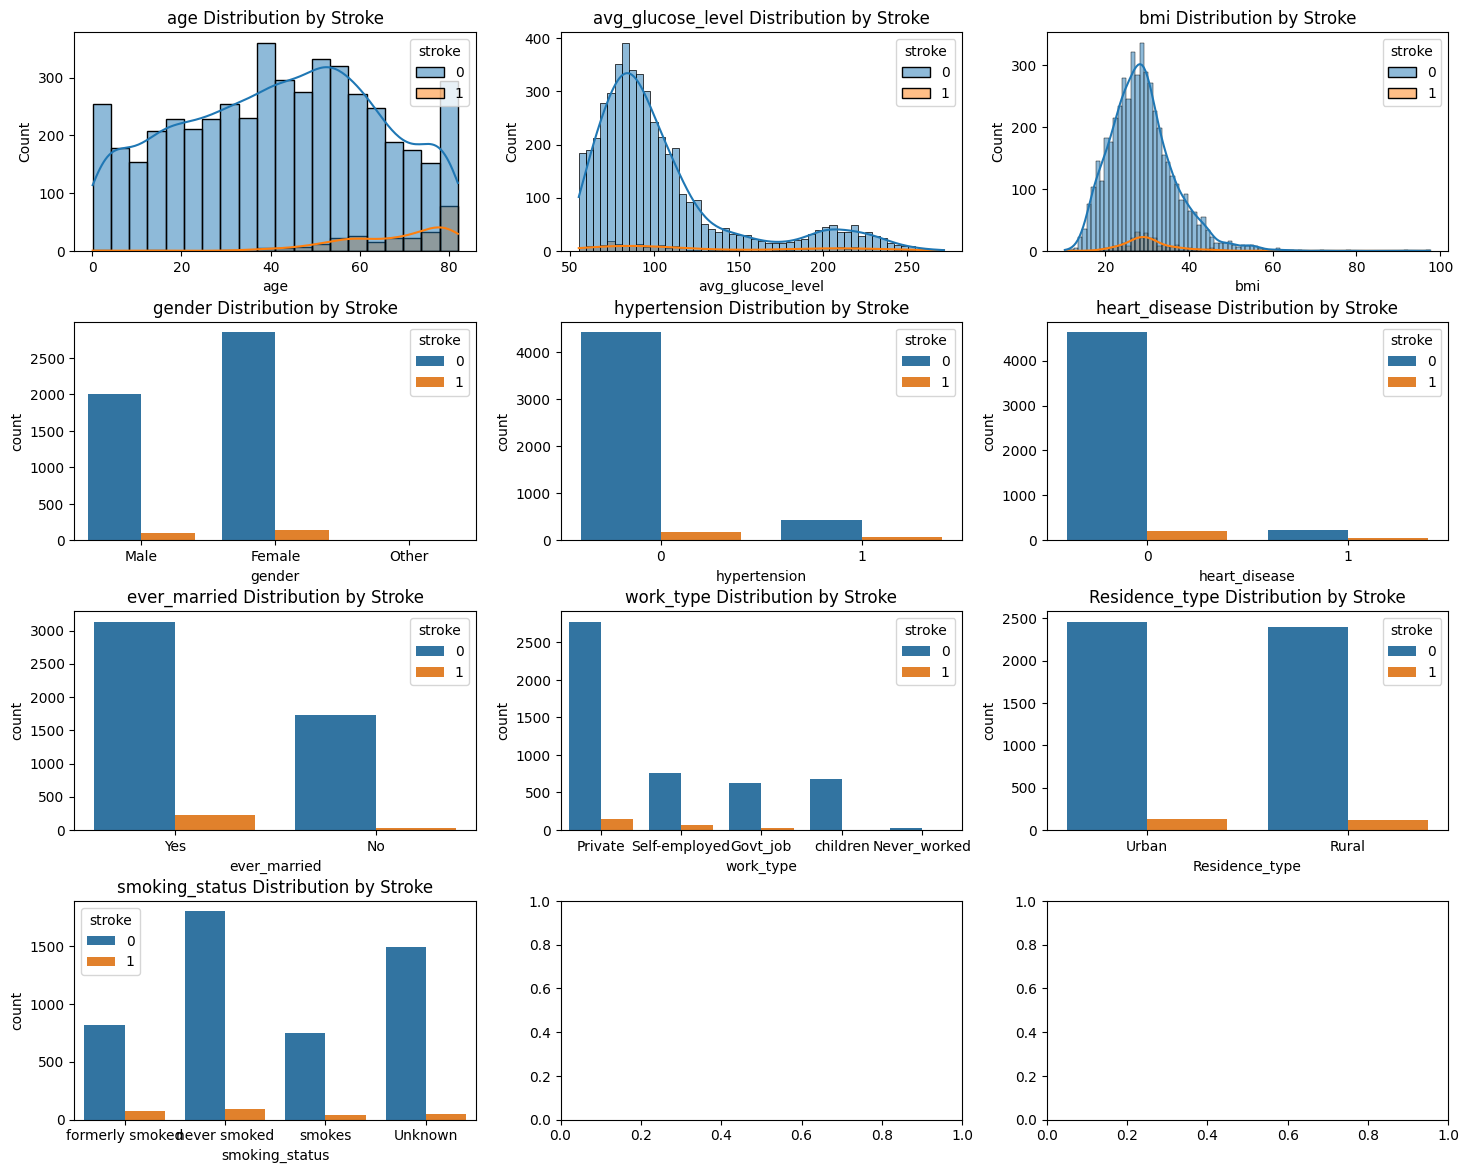

In [21]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 12))
plt.tight_layout(pad=3)
for i, col in enumerate(num_col):
    sns.histplot(data=df, x=col, hue="stroke", ax=axes[i // 3, i % 3], kde=True)
    axes[i // 3, i % 3].set_title(f"{col} Distribution by Stroke")
for i, col in enumerate(cat_col):
    sns.countplot(x=col, hue="stroke", data=df, ax=axes[(i + 3) // 3, (i + 3) % 3])
    axes[(i + 3) // 3, (i + 3) % 3].set_title(f"{col} Distribution by Stroke")
plt.show()

According to distribution analysis i decided to i am not remove outlier.


In [22]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,29.45,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.40,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1


Encoding:

- Use Label Encoding: gender, ever_married, Residence_type (all binary).
- Use One-Hot Encoding: work_type, smoking_status (multiclass categorical).


In [23]:
binary_columns = ["gender", "ever_married", "Residence_type"]
multiclass_columns = ["work_type", "smoking_status"]

In [24]:
label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(drop="first", sparse=False, dtype=int)

In [25]:
df_encoded = df.copy()
for col in binary_columns:
    df_encoded[col] = label_encoder.fit_transform(df_encoded[col])

In [26]:
multiclass_encoded = one_hot_encoder.fit_transform(df_encoded[multiclass_columns])
multiclass_encoded_df = pd.DataFrame(
    multiclass_encoded,
    columns=one_hot_encoder.get_feature_names_out(multiclass_columns),
)

In [27]:
df_encoded = df_encoded.drop(columns=multiclass_columns)
df_encoded = pd.concat([df_encoded, multiclass_encoded_df], axis=1)

In [28]:
df_encoded.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1,67.0,0,1,1,1,228.69,36.60,1,0,1,0,0,1,0,0
1,0,61.0,0,0,1,0,202.21,29.45,1,0,0,1,0,0,1,0
2,1,80.0,0,1,1,0,105.92,32.50,1,0,1,0,0,0,1,0
3,0,49.0,0,0,1,1,171.23,34.40,1,0,1,0,0,0,0,1
4,0,79.0,1,0,1,0,174.12,24.00,1,0,0,1,0,0,1,0


In [29]:
df_encoded.dtypes

gender                              int32
age                               float64
hypertension                        int64
heart_disease                       int64
ever_married                        int32
Residence_type                      int32
avg_glucose_level                 float64
bmi                               float64
stroke                              int64
work_type_Never_worked              int32
work_type_Private                   int32
work_type_Self-employed             int32
work_type_children                  int32
smoking_status_formerly smoked      int32
smoking_status_never smoked         int32
smoking_status_smokes               int32
dtype: object

<Axes: >

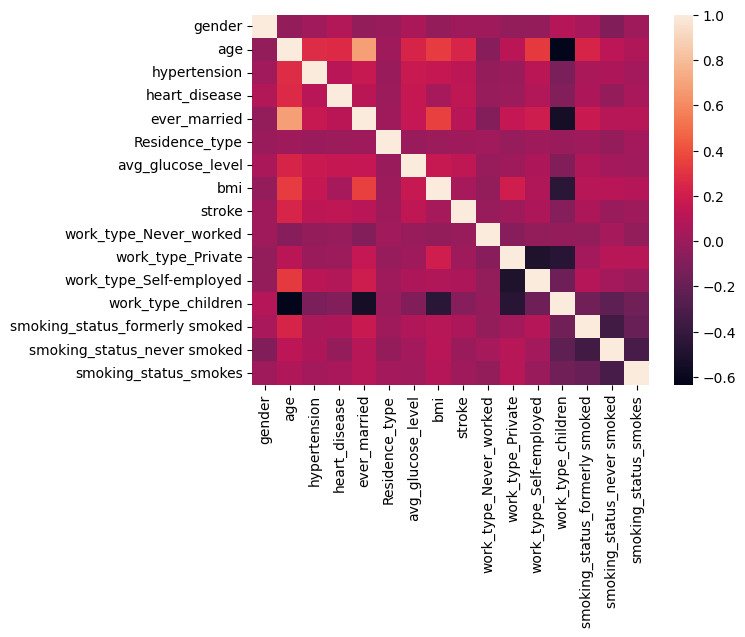

In [30]:
sns.heatmap(df_encoded.corr())

In [31]:
df_encoded["stroke"].value_counts() / len(df_encoded) * 100

0    95.127202
1     4.872798
Name: stroke, dtype: float64

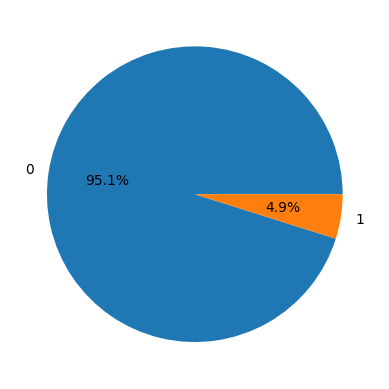

In [32]:
plt.pie(
    df_encoded["stroke"].value_counts().values,
    labels=df_encoded["stroke"].value_counts().index,
    autopct="%1.1f%%",
)

plt.show()

DATA is fully imbalanced


In [33]:
scaler = StandardScaler()

In [34]:
df_encoded[num_col] = scaler.fit_transform(df_encoded[num_col])

In [35]:
X = df_encoded.drop("stroke", axis=1)
y = df_encoded["stroke"]

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [37]:
y_train.value_counts()

0    3417
1     160
Name: stroke, dtype: int64

In [38]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [39]:
y_resampled.value_counts()

0    3417
1    3417
Name: stroke, dtype: int64

In [40]:
model_lr = LogisticRegression(
    solver="liblinear",
    random_state=42,
    max_iter=1000,
)

In [41]:
model_lr.fit(X_resampled, y_resampled)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [42]:
y_train_pred = model_lr.predict(X_resampled)
y_test_pred = model_lr.predict(X_test)

In [43]:
train_accuracy = accuracy_score(y_resampled, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

Training Accuracy: 0.81
Test Accuracy: 0.77


In [44]:
model_rf = RandomForestClassifier(
    n_estimators=100, class_weight="balanced", random_state=42,
)

In [45]:
model_rf.fit(X_resampled, y_resampled)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [46]:
y_train_pred = model_rf.predict(X_resampled)
y_test_pred = model_rf.predict(X_test)

In [47]:
train_accuracy = accuracy_score(y_resampled, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

Training Accuracy: 1.00
Test Accuracy: 0.90


In [48]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,29.45,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.40,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1


In [49]:
X = df.drop("stroke", axis=1)
y = df["stroke"]

In [50]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [51]:
categorical_features = [
    "gender",
    "ever_married",
    "work_type",
    "Residence_type",
    "smoking_status",
    "hypertension",
    "heart_disease",
]

In [52]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [53]:
train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features)
test_pool = Pool(data=X_test, cat_features=categorical_features)

In [54]:
model_cbc = CatBoostClassifier(
    learning_rate=0.1,
    depth=6,
    iterations=100,
    cat_features=categorical_features,
    verbose=0
)

In [55]:
model_cbc.fit(train_pool)

In [56]:
y_train_pred = model_cbc.predict(train_pool)
y_test_pred = model_cbc.predict(test_pool)

In [57]:
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

Training Accuracy: 0.96
Test Accuracy: 0.94


In [58]:
param_grid = {
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "depth": [4, 6, 8],
    "iterations": [100, 200, 300],
}

In [59]:
grid_search = GridSearchCV(
    estimator=CatBoostClassifier(cat_features=categorical_features,verbose=0),
    param_grid=param_grid,
    cv=5,
    scoring="roc_auc",
)

In [60]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000022F7AC54510>,
             param_grid={'depth': [4, 6, 8], 'iterations': [100, 200, 300],
                         'learning_rate': [0.01, 0.03, 0.05, 0.1]},
             scoring='roc_auc')

In [61]:
best_model = grid_search.best_estimator_

In [62]:
grid_search.best_params_

{'depth': 4, 'iterations': 100, 'learning_rate': 0.05}

In [63]:
y_train_pred = best_model.predict(train_pool)
y_test_pred = best_model.predict(test_pool)

In [64]:
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

Training Accuracy: 0.96
Test Accuracy: 0.94


In [65]:
with open("best_model.pkl", "wb") as file:
    pickle.dump(best_model, file)

In [66]:
with open("model_cbc", "wb") as file:
    pickle.dump(model_cbc, file)